## Imports

In [1]:
import torch
import shutil
import random
import glob

import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image

from torch import optim
from torch import nn

import torch.nn.functional as F

from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.datasets import ImageFolder
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision import models

#import torchvision.models as models
#from torchvision.transforms import Compose
#from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

## Data sorting

In [2]:
f1  = open("class_string.txt", "r").read().split("\n")
f2  = open("fname_string.txt", "r").read().split("\n")

class Resize(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation
        self.ratio = []

    def __call__(self, img):
        old_size = img.size  # old_size[0] is in (width, height) format

        ratio = float(self.size)/max(old_size)
        self.ratio.append(ratio)
        new_size = tuple([int(x * ratio) for x in old_size])
        
        img=img.resize(new_size, resample=self.interpolation)
        new_im = Image.new("RGB", (self.size, self.size))
        new_im.paste(img, ((self.size-new_size[0])//2,(self.size-new_size[1])//2))
        return new_im

#resize = Resize(224)
#img = resize(Image.open('train_all_test/00003.jpg'))
#img.save('train_all_test/00003.jpg') 

In [3]:
resize = Resize(224)
for fname in f2:
    img = resize(Image.open('train_all/{}'.format(fname)))
    img.save('train_all/{}'.format(fname)) 
ratio = resize.ratio

[0.37333333333333335, 0.24888888888888888, 0.35, 0.10666666666666667, 1.5555555555555556, 0.38956521739130434, 0.35, 0.350547730829421, 0.175, 0.35, 0.35, 0.448, 0.448, 0.28, 0.35, 0.35, 0.8648648648648649, 1.12, 0.14933333333333335, 0.224, 0.2986666666666667, 0.10666666666666667, 0.448, 0.21875, 0.3708609271523179, 0.35668789808917195, 0.35555555555555557, 0.36129032258064514, 0.14, 0.25, 0.21875, 0.448, 0.21875, 0.35, 0.178060413354531, 0.38620689655172413, 0.35, 0.4666666666666667, 0.35, 0.2986666666666667, 0.35, 0.35, 0.37583892617449666, 0.33990895295902884, 0.448, 0.28498727735368956, 0.14, 0.27552275522755226, 0.14, 0.38620689655172413, 0.35, 0.27722772277227725, 0.448, 0.14, 0.36129032258064514, 0.448, 0.18666666666666668, 0.8615384615384616, 0.35, 0.56, 0.21896383186705767, 0.49777777777777776, 0.21705426356589147, 0.21875, 0.448, 0.8648648648648649, 0.35, 0.35, 0.28, 0.14, 0.3483670295489891, 0.175, 0.7, 0.7, 0.4072727272727273, 0.7466666666666667, 0.06306306306306306, 0.35, 

In [4]:
f1  = open("class_string.txt", "r").read().split("\n")
f2  = open("fname_string.txt", "r").read().split("\n")
f3 = open("bbox.txt", "r").read().split("\n")
totbbox = []
for ind, line in enumerate(f3):
    f1[ind] = int(f1[ind])-1
    bbox = line.split("\t") # x1,y1,x2,y2
    bbox[0] = int(bbox[0])
    bbox[1] = int(bbox[1])
    bbox[2] = int(bbox[2])
    bbox[3] = int(bbox[3])
    bbox[0] = int(bbox[0]*ratio[ind])
    bbox[1] = int(bbox[1]*ratio[ind])
    bbox[2] = int(bbox[2]*ratio[ind])
    bbox[3] = int(bbox[3]*ratio[ind])
    totbbox.append(bbox)
#totbbox = torch.tensor(totbbox,dtype=torch.float32)
fin_list = []
for i in range(len(f2)):
    fin_list.append([f2[i],f1[i],totbbox[i][0],totbbox[i][1],totbbox[i][2],totbbox[i][3]])
print(fin_list[0][:])
df = pd.DataFrame(fin_list, columns=['image_id','labels', 'x0','y0','x1','y1'])

f1_set = set(f1)
print(f1_set.union(f1_set))

['00001.jpg', 13, 14, 43, 212, 140]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195}


In [4]:
train_all_path = Path.cwd() / "train_all"

all_filenames = list(train_all_path.glob("*.jpg"))
all_filenames_length = len(all_filenames)
#print(all_filenames)

train_filenames = random.sample(all_filenames, int(0.8*all_filenames_length))
#print(train_filenames)
val_filenames=[]
for file in all_filenames:
    if file not in train_filenames:
        val_filenames.append(file)
        
        
for subdirectory in range(1,197):
    subdirectory = Path("train/{}".format(subdirectory))
    subdirectory.mkdir(parents=True, exist_ok=True)
for subdirectory in range(1,197):
    subdirectory = Path("val/{}".format(subdirectory))
    subdirectory.mkdir(parents=True, exist_ok=True)
    

     
for index in range(all_filenames_length):
    rand = np.random.rand()
    if rand < 0.8:
        shutil.copyfile(all_filenames[index], Path.cwd() / "train/{}/{}".format(f1[index],f2[index]))
    else:
        shutil.copyfile(all_filenames[index], Path.cwd() / "val/{}/{}".format(f1[index],f2[index]))
    

## Data Handler


In [5]:
def compare_transforms(transformations, index):
    """Visually compare transformations side by side.
    Takes a list of ImageFolder datasets with different compositions of transformations.
    It then display the `index`th image of the dataset for each transformed dataset in the list.
    
    Example usage:
        compare_transforms([dataset_with_transform_1, dataset_with_transform_2], 0)
    
    Args:
        transformations (list(ImageFolder)): list of ImageFolder instances with different transformations
        index (int): Index of the sample in the ImageFolder you wish to compare.
    """
    
    # Here we combine two neat functions from basic python to validate the input to the function:
    # - `all` takes an iterable (something we can loop over, like a list) of booleans
    #    and returns True if every element is True, otherwise it returns False.
    # - `isinstance` checks whether a variable is an instance of a particular type (class)
    if not all(isinstance(transf, ImageFolder) for transf in transformations):
        raise TypeError("All elements in the `transformations` list need to be of type ImageFolder")
        
    num_transformations = len(transformations)
    fig, axes = plt.subplots(1, num_transformations)
    
    # This is just a hack to make sure that `axes` is a list of the same length as `transformations`.
    # If we only have one element in the list, `plt.subplots` will not create a list of a single axis
    # but rather just an axis without a list.
    if num_transformations == 1:
        axes = [axes]
        
    for counter, (axis, transf) in enumerate(zip(axes, transformations)):
        axis.set_title("transf: {}".format(counter))
        image_tensor = transf[index][0]
        display_image(axis, image_tensor)

    plt.show()

def display_image(axis, image_tensor):
    """Display a tensor as image
    
    Example usage:
        _, axis = plt.subplots()
        some_random_index = 453
        image_tensor, _ = train_dataset[some_random_index]
        display_image(axis, image_tensor)
    
    Args:
        axis (pyplot axis)
        image_tensor (torch.Tensor): tensor with shape (num_channels=3, width, heigth)
    """
    
    # See hint above
    if not isinstance(image_tensor, torch.Tensor):
        raise TypeError("The `display_image` function expects a `torch.Tensor` " +
                        "use the `ToTensor` transformation to convert the images to tensors.")
        
    # The imshow commands expects a `numpy array` with shape (3, width, height)
    # We rearrange the dimensions with `permute` and then convert it to `numpy`
    image_data = image_tensor.permute(1, 2, 0).numpy()
    height, width, _ = image_data.shape
    axis.imshow(image_data)
    axis.set_xlim(0, width)
    # By convention when working with images, the origin is at the top left corner.
    # Therefore, we switch the order of the y limits.
    axis.set_ylim(height, 0)

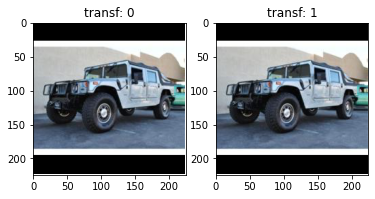

In [6]:
train_path = Path.cwd() / "train"
val_path = Path.cwd() / "val"

transform = transforms.Compose([transforms.ToTensor()])
transform1 = transforms.Compose([transforms.ToTensor()])
train_folder = ImageFolder(train_path, transform=transform)
train_folder1 = ImageFolder(train_path, transform=transform1)
val_folder = ImageFolder(val_path, transform=transform)

train_loaded = DataLoader(train_folder, batch_size=32, shuffle = True)
val_loaded = DataLoader(val_folder, batch_size=32)
compare_transforms([train_folder, train_folder1], 0)

In [5]:


class CarDataset(Dataset):
    def __init__(self, df, image_dir, transforms= None):
        super().__init__()
        
        self.df = df
        self.image_ids = self.df['image_id']
        self.image_dir = image_dir
        self.labels = self.df['labels']
        
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.df[self.df["image_id"]==image_id]
        
        img = Image.open(self.image_dir/image_id)
        img = transforms.ToTensor()(img)
        
        boxes = records[["x0","y0", "x1", "y1"]].values
        boxes = torch.tensor(boxes)
        boxes = boxes.type(torch.FloatTensor)
        labels = records["labels"].values
        labels = torch.tensor(labels, dtype = torch.int64)
        
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["image_id"] = torch.tensor([idx])
        
        return img, target
                            
                                  
                                  
    def __len__(self):
        return self.image_ids.shape[0]
    
    
    
def my_collate(batch):
    #data = torch.tensor()
    #for i, item in enumerate(batch):
        #data[i,:] = item[0]
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    #data = torch.tensor(data)
    return data, target
    
    
        
dataset = CarDataset(df, Path.cwd() / "train_all", f1)
        
datloaded = DataLoader(dataset, batch_size=8, collate_fn = my_collate)        

print(datloaded)


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = models.detection.fasterrcnn_resnet50_fpn(pretrained = True)


classes = 196
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,classes)



#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model.to(device);
num_epochs = 1
for epoch in range(num_epochs):
    for b_x, b_y in datloaded:
        out_put=model(b_x,b_y)
        print(out_put)

{'loss_classifier': tensor(5.3541, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0793, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0103, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0066, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(5.3555, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0780, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0057, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0089, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(5.3558, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0779, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0090, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0093, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(5.3798, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0616, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0040, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_bo

## Setting up architecture


In [8]:
vgg16 = models.vgg16(pretrained=True)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained = True)


features=list(vgg16.features.children())[:-1]
feature_extractor=nn.Sequential(*features)

print(feature_extractor)
for b_x, b_y in train_loaded:
    a=feature_extractor(b_x)
    break
print(a.shape)



class ClassifierLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.fullyConnected1 = nn.Linear(vgg16.classifier[0].in_features, 4096)
        self.fullyConnected2 = nn.Linear(4096, 196)

    def forward(self, x):
        #x = x.view(-1, vgg16.classifier[0].in_features)
        x = F.relu(self.fullyConnected1(x))
        x = self.fullyConnected2(x)
        return F.log_softmax(x, dim=1)
    
vgg16.classifier=ClassifierLayer()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\David/.cache\torch\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|███████████████████████████████████████████████████████████████████████████████| 160M/160M [00:55<00:00, 3.01MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 224 and 768 in dimension 2 at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensor.cpp:689

## Training


In [6]:
f3 = open("bbox.txt", "r").read().split("\n")
totbbox = []
for line in f3:
    bbox = line.split("\t") # x1,y1,x2,y2
    bbox[0] = int(bbox[0])
    bbox[1] = int(bbox[1])
    bbox[2] = int(bbox[2])
    bbox[3] = int(bbox[3])
    totbbox.append(bbox)
totbbox = torch.tensor(totbbox,dtype=torch.float32)

In [10]:
print(totbbox)
print(totbbox[1,:])

tensor([[  39.,  116.,  569.,  375.],
        [  36.,  116.,  868.,  587.],
        [  85.,  109.,  601.,  381.],
        ...,
        [  26.,  246.,  660.,  449.],
        [  78.,  526., 1489.,  908.],
        [  20.,  240.,  862.,  677.]])
tensor([ 36., 116., 868., 587.])
